In [67]:
# Environment details
# env_name        = "Measurement Regret Environment (c=0.1)"
# fileName_env    = "Loss_01"
# has_ideal_line  = True
# ideal_value     = 0.875

# env_name        = "Measurement Regret Environment (c=0.2)"
# fileName_env    = "Loss_02"
# has_ideal_line  = True
# ideal_value     = 0.8

# env_name        = "Measurement Regret Environment (c=0.05)"
# fileName_env    = "Loss_005"
# has_ideal_line  = True
# ideal_value     = 0.938

env_name        = "4x4 Frozen Lake Environment (semi-slippery)"
fileName_env    = "Lake_standard4_semi-slippery"
has_ideal_line  = False

# env_name        = "4x4 Frozen Lake Environment (slippery)"
# fileName_env    = "Lake_standard4_slippery"
# has_ideal_line  = False

# env_name        = "4x4 Frozen Lake Environment (deterministic)"
# fileName_env    = "Lake_standard4_det"
# has_ideal_line  = False

# env_name        = "8x8 Frozen Lake Environment (semi-slippery)"
# fileName_env    = "Lake_standard8_semi-slippery"
# has_ideal_line  = False

# env_name        = "12x12 Frozen Lake Environment (semi-slippery)"
# fileName_env    = "Lake_random12_semi-slippery"
# has_ideal_line  = False

# env_name        = "16x16 Frozen Lake Environment (semi-slippery)"
# fileName_env    = "Lake_random16_semi-slippery"
# has_ideal_line  = False

# env_name        = "20x20 Frozen Lake Environment (semi-slippery)"
# fileName_env    = "Lake_random20_semi-slippery"
# has_ideal_line  = False


# Algorithm details
# fileName_alg    = ["BAM_QMDP", "BAM_QMDP+", "AMRL", "ACNO_OTP"]
# legend_alg      = ["ATMQ",  "Dyna-ATMQ", "AMRL-Q","ACNO-OTP" ]

fileName_alg    = ["BAM_QMDP", "BAM_QMDP+", "AMRL"]
legend_alg      = ["ATMQ",  "Dyna-ATMQ", "AMRL-Q" ]

import numpy as np
# Plotting variables
max_eps         = 300 # np.inf       # Overrides x-axis if too big 
interval        = 0.95      # Determines confidence interval
w1, w2          = 50,1      # Determine smooting window and order

# Filename details (should stay constant!)
Data_path       = "Data/Run2/"
fileName_begin  = "AMData"
fileName_end    = ".json"

In [68]:
# creating names:
Files_to_read = []
nmbr_files = len(fileName_alg)

for i in range(nmbr_files):
    Files_to_read.append("{}_{}_{}{}".format(fileName_begin,fileName_alg[i],fileName_env,fileName_end))
    
nmbr_files      = len(Files_to_read)

# Imports
import json
import math as m
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["figure.autolayout"] = True
import datetime
from scipy.signal import savgol_filter
import scipy.stats as sts
import warnings
import seaborn as sns
timestamp = datetime.datetime.now().strftime("%d%m%Y%H%M%S")

# Plot Naming

Plot_names_title    = ["Scalarized Return", "Average steps", "Average measurements"]
Plot_Y_Label        = ["Scalarized Return", "Steps", "Measurements"]
Plot_names_file     = ["Reward", "Steps", "Measures"]

nmbr_plots          = len(Plot_names_title)

In [69]:
# Data to obtain:

nmbr_steps      = []
measure_cost    = []

avg_reward,std_reward, min_reward, max_reward = [], [], [], []
avg_cum_reward      = []

avg_steps, std_steps, min_steps, max_steps = [], [], [], []
avg_measures, std_measures, min_measures, max_measures = [], [], [], []
avg_reward_noCost   = []

std_reward_test = []

nmbr_eps = []
nmbr_runs = []
measure_cost = []
# Read data:

for file_name in Files_to_read:
    with open(Data_path + file_name) as file:
        contentDict = json.load(file)
        
        avg_reward.append       ( np.average  (contentDict["reward_per_eps"]      , axis=0) )
        std_reward.append       ( np.std ( contentDict["reward_per_eps"], axis=0) ) 
        
        avg_steps.append        (np.average (contentDict["steps_per_eps"]       , axis=0)) 
        std_steps.append       ( np.std ( contentDict["steps_per_eps"] , axis=0) )
        avg_measures.append     (np.average (contentDict["measurements_per_eps"], axis=0)) 
        std_measures.append       ( np.std ( contentDict["measurements_per_eps"], axis=0))

        nmbr_eps.append     (int(contentDict["parameters"]["nmbr_eps"]))
        nmbr_runs.append    (int(contentDict["parameters"]["nmbr_runs"]))
        measure_cost.append (float(contentDict["parameters"]["m_cost"]))

all_data = [(avg_reward, std_reward), (avg_steps,std_steps), (avg_measures,std_measures)]
eps_to_plot = min(np.min(nmbr_eps), max_eps)

In [70]:
print(plt.style.available)
# plt.style.use("seaborn-colorblind")
plt.style.use("ggplot")
matplotlib.rc('lines', linewidth=2.0)

for i in range (nmbr_plots):

    #plt.title("{} in {}".format(Plot_names_title[i], env_name))
    plt.ylabel(Plot_Y_Label[i])
    plt.xlabel("Episode")
    
    x = np.arange(eps_to_plot)
    
    if has_ideal_line and i==0:
        plt.plot(x, np.repeat(ideal_value,eps_to_plot), 'k--', linewidth=1, label="optimal value")
    
    for j in range(nmbr_files):
        
        y, std = all_data[i][0][j][:eps_to_plot], all_data[i][1][j][:eps_to_plot]
        y, std = savgol_filter(y, w1,w2), savgol_filter(std, w1,w2)
        miny, maxy = sts.norm.interval(interval, loc=y, scale=std)
        plt.plot(x,y, label=legend_alg[j])
        # plt.fill_between(x, miny, maxy, alpha=0.1)

    
    plt.legend()
    plt.savefig(Data_path+"Plots/Plot_{}_{}".format(fileName_env, Plot_names_file[i]))
    if True:
        pass
        #plt.show()
    
    plt.clf()


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


<Figure size 800x600 with 0 Axes>

In [71]:
file_text = """
Data collected from running in {} , using the following algorithms:
""".format(env_name)

for (i,file_name) in enumerate(Files_to_read):
    with open(Data_path + file_name) as file:
        
        contentDict = json.load(file)
        toi = int(contentDict["parameters"]["nmbr_eps"])
        fromi = m.ceil(toi-50)
        
        rew             = np.array( contentDict["reward_per_eps"] )
        
        this_rew        = np.average  (rew)
        std_rew         = np.std (np.average( rew, axis=1))
        last_rew        = np.average  (rew[:,fromi:toi])
        last_std_rew    = np.std ( np.average( rew[:,fromi:toi], axis=1 ) )
        print(np.average( rew[:,fromi:toi], axis=1 ))
        
        steps = np.array( contentDict["steps_per_eps"] )
        this_steps = np.average  (steps)
        std_steps     = np.std (np.average( steps, axis=0))
        last_steps = np.average  (steps[:,fromi:toi])
        last_std_steps = np.std ( np.average( steps[:,fromi:toi], axis=0 ) )
        
        measures = np.array( contentDict["measurements_per_eps"] )
        this_measures = np.average  (measures)
        std_measures     = np.std (np.average( measures, axis=0))
        last_measures = np.average  (measures[:,fromi:toi])
        last_std_measures = np.std ( np.average( measures[:,fromi:toi], axis=0 ) )
        
        nmbr_eps=int(contentDict["parameters"]["nmbr_eps"])
        nmbr_runs=int(contentDict["parameters"]["nmbr_runs"])
        measure_cost=float(contentDict["parameters"]["m_cost"])



    file_text +="""
{}:
nmbr_eps                    = {}
nmbr_runs                   = {}
measure_cost                = {}

avererage reward            = {}            (with std = {})
average nmbr steps          = {}            (with std = {})
average nmbr measurements   = {}            (with std = {})

In last 1/10th of episodes:
avererage reward            = {}            (with std = {})
average nmbr steps          = {}            (with std = {})
average nmbr measurements   = {}            (with std = {})

""".format(
        fileName_alg[i],
        nmbr_eps, nmbr_runs, measure_cost,
        this_rew, std_rew, this_steps, std_steps, this_measures, std_measures,
        last_rew, last_std_rew, last_steps, last_std_steps, last_measures, last_std_measures
    )

data_file_name = Data_path+"/Compiled/Data_{}".format(fileName_env)
with open(data_file_name, 'w') as f:
    f.write(file_text)

[0.568 0.862 0.606 0.865 0.837]
[0.858 0.644 0.36  0.609 0.807]
[0.42 0.46 0.46 0.32 0.4 ]


c:\Users\merli\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\merli\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


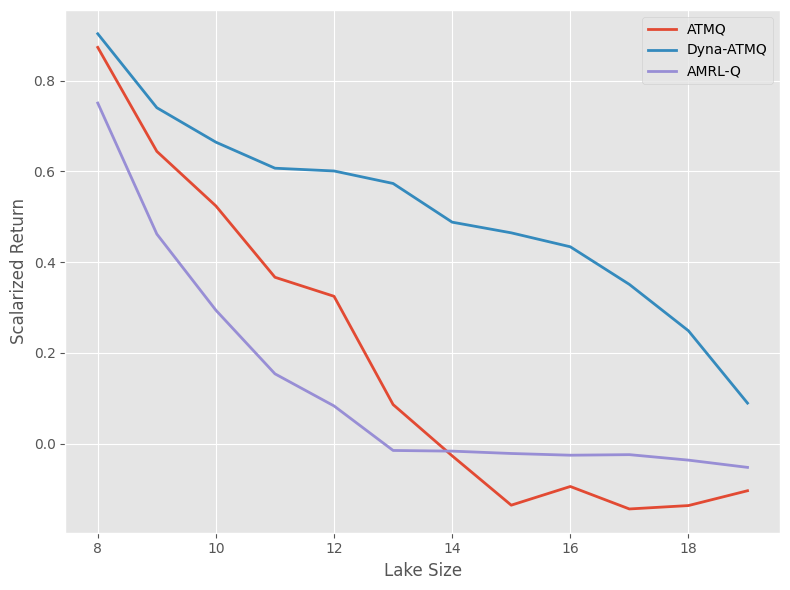

In [72]:

if True:
    

    fileName_alg    = ["BAM_QMDP", "BAM_QMDP+", "AMRL"]
    legend_alg      = ["ATMQ",  "Dyna-ATMQ", "AMRL-Q"]
    nmbr_algs       = len(fileName_alg)

    sizes = np.arange(8,20)
    nmbr_files = len(sizes)
    avg_rewards, avg_measures, std_rewards, std_measures = np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files))
    rewardsmin, rewardsmax = np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files))

    check_percentage = 0.9
    this_window, this_order = 3, 1

    # Collect all data
    for (algnmbr, algName) in enumerate(fileName_alg):
        for i in range(nmbr_files):
            filename = "AMData_{}_Lake_random{}_semi-slippery.json".format(fileName_alg[algnmbr],  str(sizes[i]))
            
            with open(Data_path + filename) as file:
                    contentDict = json.load(file)
                    
                    nmbr_eps = int(contentDict["parameters"]["nmbr_eps"])
                    toi = nmbr_eps
                    fromi = m.ceil(toi*check_percentage)
                    
                    rewards = np.array(contentDict["reward_per_eps"])[:,fromi:toi]
                    avg_rewards[algnmbr,i]  = np.average( rewards )
                    # std_rewards[algnmbr,i] = np.std(rewards)
                    std_rewards[algnmbr,i]  = np.std( np.average(rewards, axis=1) )
                    rewardsmin[algnmbr,i], rewardsmax[algnmbr,i] = sts.norm.interval(interval, loc=avg_rewards[algnmbr,i], scale=std_rewards[algnmbr,i])
            
        avg_rewards = savgol_filter( avg_rewards, this_window, this_order)
        std_rewards = savgol_filter( std_rewards, this_window, this_order)
        rewardsmin[algnmbr], rewardsmax[algnmbr] = sts.norm.interval(interval, loc=avg_rewards[algnmbr], scale=std_rewards[algnmbr])
        
        # Manually remove std for dyna-variant 
        rewardsmin[1], rewardsmax[1] = avg_rewards[1], avg_rewards[1]
        
        plt.plot(sizes, avg_rewards[algnmbr], label = legend_alg[algnmbr])
        
        # plt.fill_between(sizes, rewardsmin[algnmbr], rewardsmax[algnmbr], alpha=0.1)


    plt.ylabel("Scalarized Return")
    plt.xlabel("Lake Size")
    plt.legend()
    plt.savefig(Data_path+"Plots/LargeLakeCombined.png")
    plt.show()

In [73]:
if False:

    fileName_alg    = ["BAM_QMDP", "BAM_QMDP+", "AMRL", "ACNO_OTP"]
    legend_alg      = ["ATMQ",  "Dyna-ATMQ", "AMRL-Q","ACNO-OTP" ]
    nmbr_algs       = len(fileName_alg)
    
    this_window, this_order = 3, 1

    costs = np.linspace(start=0.05, stop=0.2, num=16)
    costs_names = ["005","006", "007", "008", "009", "01", "011", "012", "013", "014", "015", "016", "017", "018", "019", "02"]
    # costs = np.linspace(start=0.06, stop=0.2, num=8)
    # cost_names = ["006", "008", "01", "012", "014", "016", "018", "02"]
    nmbr_files = len(costs)
    avg_rewards, avg_measures, std_rewards, std_measures = np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files))
    rewardsmin, rewardsmax = np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files))

    nmbr_points = nmbr_files
    costs_extended = np.linspace(np.min(costs), np.max(costs), nmbr_points)
    optimal_line = (0.8-costs_extended) / 0.8
    optimal_line[optimal_line < 0.8] = 0.8

    # Collect all data
    for (algnmbr, algName) in enumerate(fileName_alg):
        for i in range(nmbr_files):
            filename = "AMData_{}_Loss_{}.json".format(fileName_alg[algnmbr],  str(costs_names[i]))
            
            with open(Data_path + filename) as file:
                contentDict = json.load(file)
                
                nmbr_eps = int(contentDict["parameters"]["nmbr_eps"])
                toi = nmbr_eps
                fromi = nmbr_eps-50
                
                rewards = np.array(contentDict["reward_per_eps"])[:,fromi:toi] / optimal_line[i] *100
                avg_rewards[algnmbr,i]  = np.average( rewards ) 
                std_rewards[algnmbr,i]  = np.std( np.average(rewards, axis=1) )
                rewardsmin[algnmbr,i], rewardsmax[algnmbr,i] = sts.norm.interval(interval, loc=avg_rewards[algnmbr,i], scale=std_rewards[algnmbr,i])
            
        avg_rewards = savgol_filter( avg_rewards, this_window, this_order)
        std_rewards = savgol_filter( std_rewards, this_window, this_order)
        # rewardsmin, rewardsmax = avg_rewards - std_rewards, avg_rewards + std_rewards, 
        # rewardsmin[algnmbr], rewardsmax[algnmbr] = sts.norm.interval(interval, loc=avg_rewards[algnmbr], scale=std_rewards[algnmbr])
        
        plt.plot(costs, avg_rewards[algnmbr], label = legend_alg[algnmbr])
        # plt.fill_between(costs, rewardsmin[algnmbr], rewardsmax[algnmbr], alpha=0.15)
    

    plt.plot(costs_extended, np.repeat(100,nmbr_points), 'k--', linewidth=1, label="Optimal behaviour" )
    
    #plt.title("Average Return against measuring cost")
    plt.ylabel("Average return (% of optimal)")
    plt.xlabel("Measurement Cost")
    plt.legend()
    plt.show()

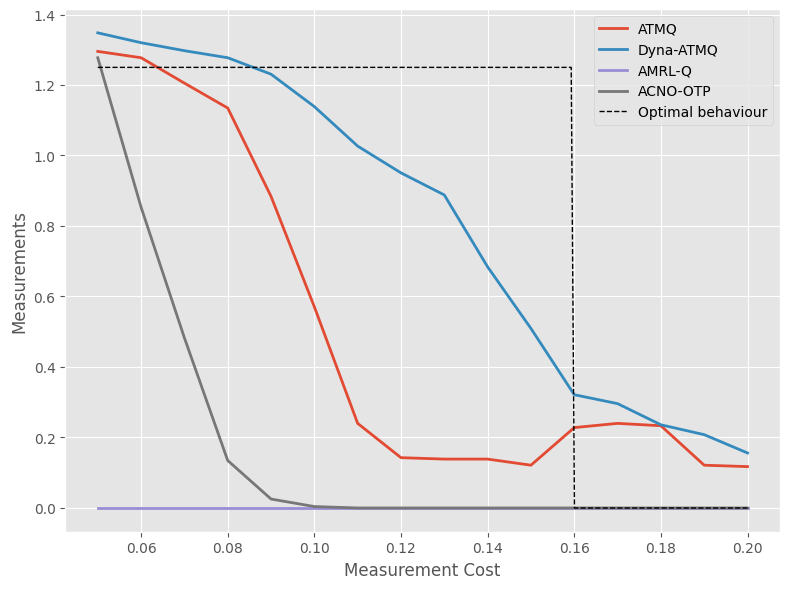

In [74]:
if True:

    fileName_alg    = ["BAM_QMDP", "BAM_QMDP+", "AMRL", "ACNO_OTP"]
    legend_alg      = ["ATMQ",  "Dyna-ATMQ", "AMRL-Q","ACNO-OTP" ]
    nmbr_algs       = len(fileName_alg)
    
    this_window, this_order = 3, 1

    costs = np.linspace(start=0.05, stop=0.2, num=16)
    costs_names = ["005","006", "007", "008", "009", "01", "011", "012", "013", "014", "015", "016", "017", "018", "019", "02"]
    # costs = np.linspace(start=0.06, stop=0.2, num=8)
    # cost_names = ["006", "008", "01", "012", "014", "016", "018", "02"]
    nmbr_files = len(costs)
    avg_rewards, avg_measures, std_rewards, std_measures = np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files))
    rewardsmin, rewardsmax = np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files))

    nmbr_points = 200
    costs_extended = np.linspace(np.min(costs), np.max(costs), nmbr_points)
    
    optimal_line = np.zeros(nmbr_points)+1.25
    optimal_line[costs_extended>0.16] = 0
    
    # plt.axvline(x=0.16, color='k', linestyle='--', label="optimal value")


    # Collect all data
    for (algnmbr, algName) in enumerate(fileName_alg):
        for i in range(nmbr_files):
            filename = "AMData_{}_Loss_{}.json".format(fileName_alg[algnmbr],  str(costs_names[i]))
            
            with open(Data_path + filename) as file:
                contentDict = json.load(file)
                
                nmbr_eps = int(contentDict["parameters"]["nmbr_eps"])
                toi = nmbr_eps
                fromi = nmbr_eps-50
                
                rewards = np.array(contentDict["measurements_per_eps"])[:,fromi:toi]
                avg_rewards[algnmbr,i]  = np.average( rewards )
                std_rewards[algnmbr,i]  = np.std( np.average(rewards, axis=1) )
                #rewardsmin[algnmbr,i], rewardsmax[algnmbr,i] = sts.norm.interval(interval, loc=avg_rewards[algnmbr,i], scale=std_rewards[algnmbr,i])
            
        avg_rewards = savgol_filter( avg_rewards, this_window, this_order)
        std_rewards = savgol_filter( std_rewards, this_window, this_order)
        rewardsmin[algnmbr], rewardsmax[algnmbr] = sts.norm.interval(interval, loc=avg_rewards[algnmbr], scale=std_rewards[algnmbr])
        
        plt.plot(costs, avg_rewards[algnmbr], label = legend_alg[algnmbr])
        # plt.fill_between(costs, rewardsmin[algnmbr], rewardsmax[algnmbr], alpha=0.15)
    #plt.title("Average Return against measuring cost")
    
    plt.plot(costs_extended, optimal_line, 'k--',linewidth=1, label="Optimal behaviour")
    
    plt.ylabel("Measurements")
    plt.xlabel("Measurement Cost")
    plt.legend()
    plt.savefig(Data_path+"Plots/RegretCostsCombinedMeasures.png")
    plt.show()

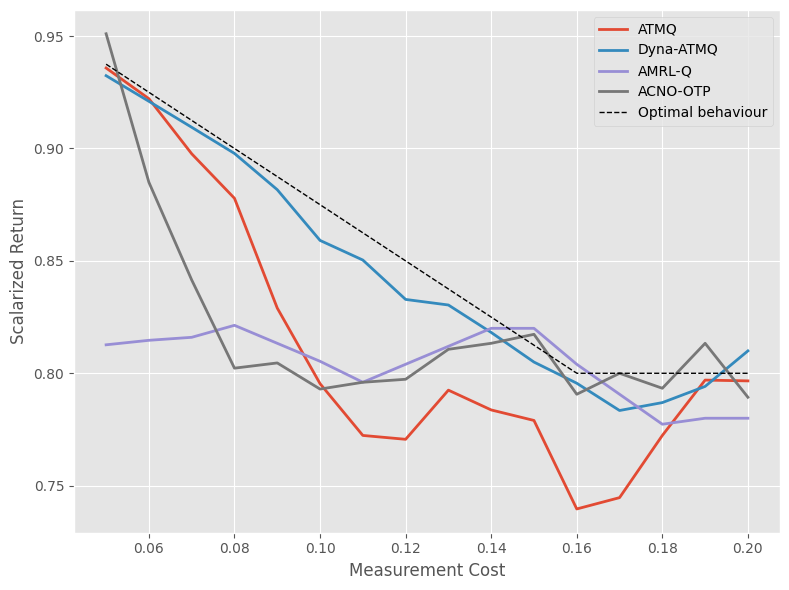

In [75]:
if True:

    fileName_alg    = ["BAM_QMDP", "BAM_QMDP+", "AMRL", "ACNO_OTP"]
    legend_alg      = ["ATMQ",  "Dyna-ATMQ", "AMRL-Q","ACNO-OTP" ]
    nmbr_algs       = len(fileName_alg)
    
    this_window, this_order = 3, 1

    costs = np.linspace(start=0.05, stop=0.2, num=16)
    costs_names = ["005","006", "007", "008", "009", "01", "011", "012", "013", "014", "015", "016", "017", "018", "019", "02"]
    # costs = np.linspace(start=0.06, stop=0.2, num=8)
    # cost_names = ["006", "008", "01", "012", "014", "016", "018", "02"]
    nmbr_files = len(costs)
    avg_rewards, avg_measures, std_rewards, std_measures = np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files))
    rewardsmin, rewardsmax = np.zeros((nmbr_algs, nmbr_files)), np.zeros((nmbr_algs, nmbr_files))

    nmbr_points = 200
    costs_extended = np.linspace(np.min(costs), np.max(costs), nmbr_points)
    optimal_line = (0.8-costs_extended) / 0.8
    optimal_line[optimal_line < 0.8] = 0.8
    
    
    # plt.axvline(x=0.16, color='k', linestyle='--', label="optimal value")


    # Collect all data
    for (algnmbr, algName) in enumerate(fileName_alg):
        for i in range(nmbr_files):
            filename = "AMData_{}_Loss_{}.json".format(fileName_alg[algnmbr],  str(costs_names[i]))
            
            with open(Data_path + filename) as file:
                contentDict = json.load(file)
                
                nmbr_eps = int(contentDict["parameters"]["nmbr_eps"])
                toi = nmbr_eps
                fromi = nmbr_eps-50
                
                rewards = np.array(contentDict["reward_per_eps"])[:,fromi:toi]
                avg_rewards[algnmbr,i]  = np.average( rewards )
                std_rewards[algnmbr,i]  = np.std( np.average(rewards, axis=1) )
                #rewardsmin[algnmbr,i], rewardsmax[algnmbr,i] = sts.norm.interval(interval, loc=avg_rewards[algnmbr,i], scale=std_rewards[algnmbr,i])
            
        avg_rewards = savgol_filter( avg_rewards, this_window, this_order)
        std_rewards = savgol_filter( std_rewards, this_window, this_order)
        rewardsmin[algnmbr], rewardsmax[algnmbr] = sts.norm.interval(interval, loc=avg_rewards[algnmbr], scale=std_rewards[algnmbr])
        rewardsmin, rewardsmax = avg_rewards - std_rewards, avg_rewards + std_rewards, 
        
        plt.plot(costs, avg_rewards[algnmbr], label = legend_alg[algnmbr])
        # plt.fill_between(costs, rewardsmin[algnmbr], rewardsmax[algnmbr], alpha=0.15)
        # plt.ylim(ymin=0.73, ymax=0.97)

    plt.plot(costs_extended, optimal_line, 'k--',linewidth=1, label="Optimal behaviour")
    plt.ylabel("Scalarized Return")
    
    plt.xlabel("Measurement Cost")
    plt.legend()
    plt.savefig(Data_path+"Plots/RegretCostsCombined.png")
    plt.show()